In [5]:
# Imports and data loading

import pandas as pd
import matplotlib.pyplot as plt

# Load trading data
ftmo_trades = pd.read_csv(
    "C:\\Users\\blazo\\Documents\\Misc\\QJ\\quant-journey\\research\\ftmo\\data\\ftmo_old.csv"
)

# Convert Close column to datetime
ftmo_trades['Close'] = pd.to_datetime(ftmo_trades['Close'])

# Calculate total PnL
ftmo_trades['pnl'] = ftmo_trades['Swap'] + ftmo_trades['Commissions'] + ftmo_trades['Profit']

# Define symbol groups
z6p_symbols = ['AUDCAD', 'GBPNZD', 'GBPAUD', 'AUDNZD', 'AUDUSD']
z7_symbols = ['USDJPY', 'EURCHF', 'GBPUSD']

# Filter and process z6p trades
z6p_trades = ftmo_trades[ftmo_trades['Symbol'].isin(z6p_symbols)].copy()
z6p_trades = z6p_trades.sort_values('Close')
z6p_trades['equity'] = z6p_trades['pnl'].cumsum()

# Filter and process z7 trades
z7_trades = ftmo_trades[ftmo_trades['Symbol'].isin(z7_symbols)].copy()
z7_trades = z7_trades.sort_values('Close')
z7_trades['equity'] = z7_trades['pnl'].cumsum()

In [6]:
# Summary of overall performance

print("\n" + "=" * 80)
print("COMPARATIVE SUMMARY")
print("=" * 80)
print(f"Z6+ Performance: ${z6p_trades['pnl'].sum():.2f} ({len(z6p_trades)} trades)")
print(f"Z7 Performance: ${z7_trades['pnl'].sum():.2f} ({len(z7_trades)} trades)")
print(f"Combined Performance: ${ftmo_trades['pnl'].sum():.2f} ({len(ftmo_trades)} trades)")

# Calculate win/loss statistics for each strategy
z6p_wins = z6p_trades[z6p_trades['pnl'] > 0]['pnl']
z6p_losses = z6p_trades[z6p_trades['pnl'] <= 0]['pnl']
z7_wins = z7_trades[z7_trades['pnl'] > 0]['pnl']
z7_losses = z7_trades[z7_trades['pnl'] <= 0]['pnl']

print(f"\nZ6+ Statistics:")
print(f"  Average Trades per Day: {len(z6p_trades) / z6p_trades['Close'].dt.date.nunique():.2f}")
print(f"  Average Win: ${z6p_wins.mean():.2f} ({len(z6p_wins)} winning trades)")
print(f"  Average Loss: ${z6p_losses.mean():.2f} ({len(z6p_losses)} losing trades)")
print(f"  Win/Loss Ratio: {(len(z6p_wins) / (len(z6p_losses))):.2f}")
print(f"  Win Percentage: {(len(z6p_wins) / (len(z6p_wins) + len(z6p_losses))) * 100:.2f} %")

print(f"\nZ7 Statistics:")
print(f"  Average Trades per Day: {len(z7_trades) / z7_trades['Close'].dt.date.nunique():.2f}")
print(f"  Average Win: ${z7_wins.mean():.2f} ({len(z7_wins)} winning trades)")
print(f"  Average Loss: ${z7_losses.mean():.2f} ({len(z7_losses)} losing trades)")
print(f"  Win/Loss Ratio: {(len(z7_wins) / (len(z7_losses))):.2f}")
print(f"  Win Percentage: {(len(z7_wins) / (len(z7_wins) + len(z7_losses))) * 100:.2f} %")
print("=" * 80)


COMPARATIVE SUMMARY
Z6+ Performance: $758.11 (479 trades)
Z7 Performance: $-711.97 (160 trades)
Combined Performance: $46.14 (639 trades)

Z6+ Statistics:
  Average Trades per Day: 19.96
  Average Win: $20.43 (327 winning trades)
  Average Loss: $-38.97 (152 losing trades)
  Win/Loss Ratio: 2.15
  Win Percentage: 68.27 %

Z7 Statistics:
  Average Trades per Day: 6.15
  Average Win: $51.34 (69 winning trades)
  Average Loss: $-46.75 (91 losing trades)
  Win/Loss Ratio: 0.76
  Win Percentage: 43.12 %


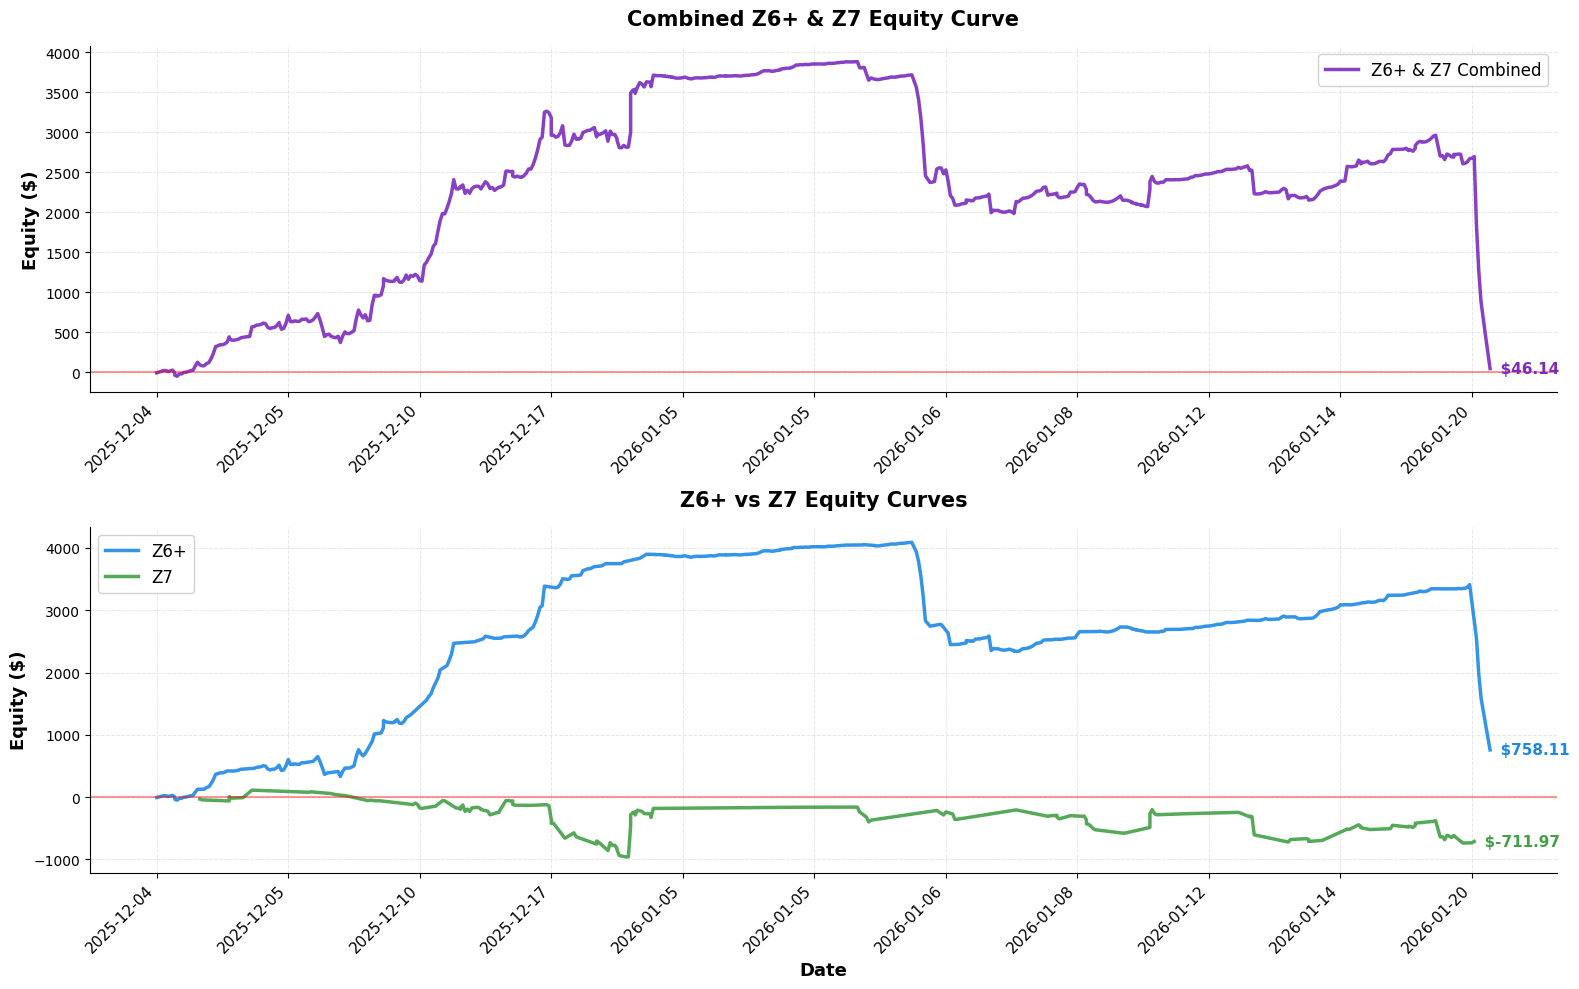

In [7]:
# Combined and separate equity curves plotting

# Convert Close column to datetime if not already done
z6p_trades['Close'] = pd.to_datetime(z6p_trades['Close'])
z7_trades['Close'] = pd.to_datetime(z7_trades['Close'])

# Combine all unique dates from both dataframes
all_dates = pd.concat([z6p_trades['Close'], z7_trades['Close']]).drop_duplicates().sort_values()

# Create a mapping from dates to integer positions
date_to_idx = {date: idx for idx, date in enumerate(all_dates)}

# Map the dates to positions for each dataframe
z6p_positions = z6p_trades['Close'].map(date_to_idx)
z7_positions = z7_trades['Close'].map(date_to_idx)

# Combine z6p and z7 trades and sort by close time
combined_trades = pd.concat([z6p_trades, z7_trades]).sort_values('Close')
combined_trades['combined_equity'] = combined_trades['pnl'].cumsum()

# Map the combined trades to positions
combined_positions = combined_trades['Close'].map(date_to_idx)

# Create the plot with 2 subplots
fig, axs = plt.subplots(2, 1, figsize=(16, 10))

# Top plot: Combined equity curve
axs[0].plot(combined_positions, combined_trades['combined_equity'].values, 
           linewidth=2.5, color='#7B2CBF', label='Z6+ & Z7 Combined', alpha=0.9)

# Add final value annotation for combined
final_combined_value = combined_trades['combined_equity'].iloc[-1]
final_combined_pos = combined_positions.iloc[-1]
axs[0].text(final_combined_pos, final_combined_value, f'  ${final_combined_value:.2f}', 
           va='center', ha='left', fontsize=11, fontweight='bold', color='#7B2CBF')

axs[0].set_ylabel('Equity ($)', fontsize=13, fontweight='bold')
axs[0].set_title('Combined Z6+ & Z7 Equity Curve', fontsize=15, fontweight='bold', pad=15)
axs[0].legend(fontsize=12, loc='best', framealpha=0.9)
axs[0].grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
axs[0].axhline(y=0, color='red', linestyle='-', linewidth=1.5, alpha=0.4)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

# Bottom plot: Individual equity curves
axs[1].plot(z6p_positions, z6p_trades['equity'].values, linewidth=2.5, 
           color='#1E88E5', label='Z6+', alpha=0.9)
axs[1].plot(z7_positions, z7_trades['equity'].values, linewidth=2.5, 
           color='#43A047', label='Z7', alpha=0.9)

# Add final value annotations
final_z6p_value = z6p_trades['equity'].iloc[-1]
final_z6p_pos = z6p_positions.iloc[-1]
axs[1].text(final_z6p_pos, final_z6p_value, f'  ${final_z6p_value:.2f}', 
           va='center', ha='left', fontsize=11, fontweight='bold', color='#1E88E5')

final_z7_value = z7_trades['equity'].iloc[-1]
final_z7_pos = z7_positions.iloc[-1]
axs[1].text(final_z7_pos, final_z7_value, f'  ${final_z7_value:.2f}', 
           va='center', ha='left', fontsize=11, fontweight='bold', color='#43A047')

axs[1].set_xlabel('Date', fontsize=13, fontweight='bold')
axs[1].set_ylabel('Equity ($)', fontsize=13, fontweight='bold')
axs[1].set_title('Z6+ vs Z7 Equity Curves', fontsize=15, fontweight='bold', pad=15)
axs[1].legend(fontsize=12, loc='best', framealpha=0.9)
axs[1].grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
axs[1].axhline(y=0, color='red', linestyle='-', linewidth=1.5, alpha=0.4)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

# Set custom x-axis labels for both plots with better spacing
tick_interval = max(1, len(all_dates) // 10)
tick_positions = list(range(0, len(all_dates), tick_interval))
for ax in axs:
    ax.set_xticks(tick_positions)
    ax.set_xticklabels([all_dates.iloc[i].strftime('%Y-%m-%d') for i in tick_positions], 
                       rotation=45, ha='right', fontsize=11)

plt.tight_layout()
plt.show()

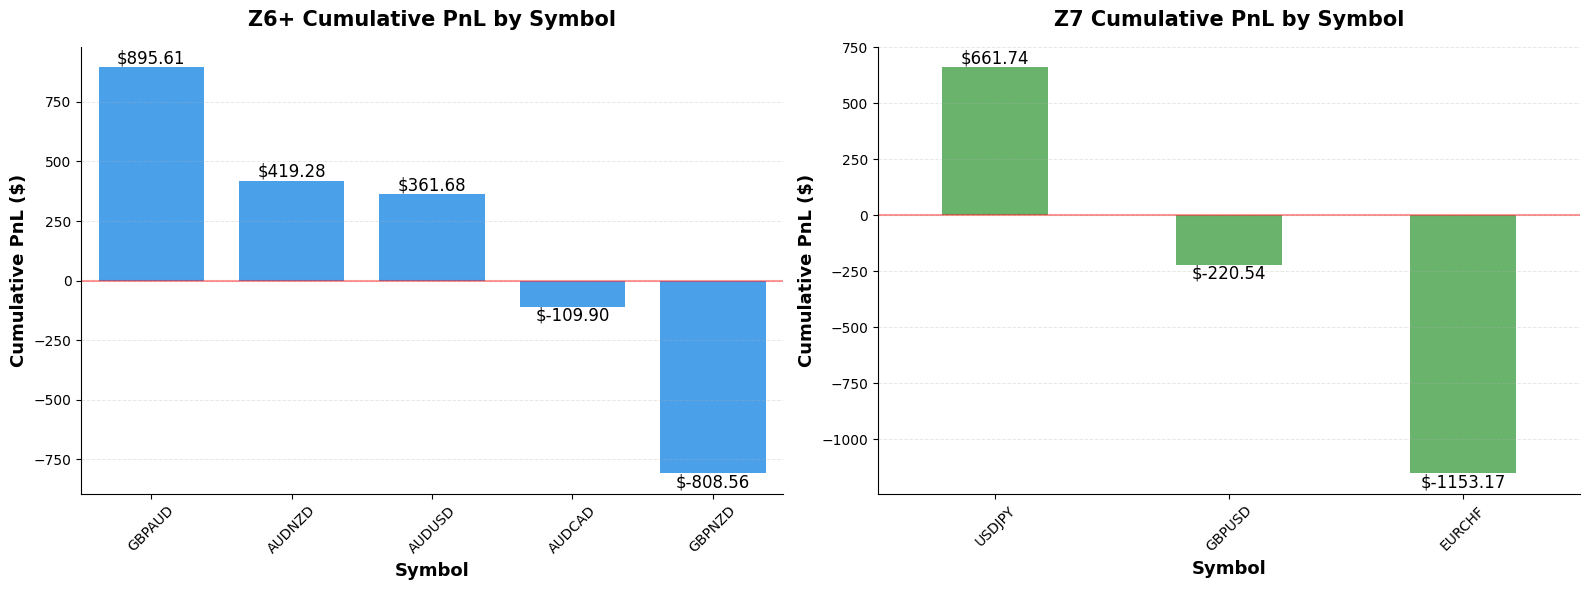

In [8]:
# Create histogram-like plots for Z6+ and Z7 showing cumulative PnL by symbol
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Calculate absolute bar width based on figure dimensions
# Each subplot is ~8 inches wide, and we want consistent bar width
desired_bar_width_inches = 1.2  # Adjust this value to change absolute bar size
subplot_width_inches = 8  # Half of the 16-inch figure width

# Z6+ cumulative PnL by symbol
z6p_symbol_pnl = z6p_trades.groupby('Symbol')['pnl'].sum().sort_values(ascending=False)
x_positions_z6p = range(len(z6p_symbol_pnl))
# Convert inches to data coordinates for Z6+ subplot
bar_width_z6p = (desired_bar_width_inches / subplot_width_inches) * len(z6p_symbol_pnl)
axs[0].bar(x_positions_z6p, z6p_symbol_pnl.values, width=bar_width_z6p, color='#1E88E5', alpha=0.8)
axs[0].set_xticks(x_positions_z6p)
axs[0].set_xticklabels(z6p_symbol_pnl.index, rotation=45)
axs[0].set_xlabel('Symbol', fontsize=13, fontweight='bold')
axs[0].set_ylabel('Cumulative PnL ($)', fontsize=13, fontweight='bold')
axs[0].set_title('Z6+ Cumulative PnL by Symbol', fontsize=15, fontweight='bold', pad=15)
axs[0].grid(True, alpha=0.3, linestyle='--', linewidth=0.7, axis='y')
axs[0].axhline(y=0, color='red', linestyle='-', linewidth=1.5, alpha=0.4)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].set_xlim(-0.5, len(z6p_symbol_pnl) - 0.5)

# Add value labels on bars
for i, (symbol, value) in enumerate(z6p_symbol_pnl.items()):
    axs[0].text(i, value, f'${value:.2f}', ha='center', va='bottom' if value > 0 else 'top', 
                fontsize=12)

# Z7 cumulative PnL by symbol
z7_symbol_pnl = z7_trades.groupby('Symbol')['pnl'].sum().sort_values(ascending=False)
x_positions_z7 = range(len(z7_symbol_pnl))
# Convert inches to data coordinates for Z7 subplot
bar_width_z7 = (desired_bar_width_inches / subplot_width_inches) * len(z7_symbol_pnl)
axs[1].bar(x_positions_z7, z7_symbol_pnl.values, width=bar_width_z7, color='#43A047', alpha=0.8)
axs[1].set_xticks(x_positions_z7)
axs[1].set_xticklabels(z7_symbol_pnl.index, rotation=45)
axs[1].set_xlabel('Symbol', fontsize=13, fontweight='bold')
axs[1].set_ylabel('Cumulative PnL ($)', fontsize=13, fontweight='bold')
axs[1].set_title('Z7 Cumulative PnL by Symbol', fontsize=15, fontweight='bold', pad=15)
axs[1].grid(True, alpha=0.3, linestyle='--', linewidth=0.7, axis='y')
axs[1].axhline(y=0, color='red', linestyle='-', linewidth=1.5, alpha=0.4)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].set_xlim(-0.5, len(z7_symbol_pnl) - 0.5)

# Add value labels on bars
for i, (symbol, value) in enumerate(z7_symbol_pnl.items()):
    axs[1].text(i, value, f'${value:.2f}', ha='center', va='bottom' if value > 0 else 'top', 
                fontsize=12)

plt.tight_layout()
plt.show()